<a href="https://colab.research.google.com/github/ktongk/BTT-JPMC-1/blob/main/scrape_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtaining a list of equities tickers and the corresponding timeseries

In [63]:
! pip install --quiet yfinance ##--quiet mutes the package list as it’s installing

In [64]:
import os
import json
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import matplotlib.pyplot as plt


from datetime import datetime
''
# this workaround let's us override pandas_datareader with yfinance,
# although we can also use yfinance directly
import yfinance as yf
import pandas_datareader.data as web; yf.pdr_override()

In [65]:
# from google.colab import drive
# drive.mount('/content/drive')

In [66]:
start_date = '2023-03-02'
end_date  = '2023-03-21'

data_dir = 'data'

#A Timeline on the SVB Crash and why we Chose it

According to Investopedia, SVB Financial Group was removed from the S&P 500 Index due to the collapse its bank. So the most recent rebalancing of S&P 500 was announced on March 10, 2023.

The bank, mostly focused on venture capital funds and small tech startups had a huge boom during the pandemic. The bank then invested all of its profits into low-return bonds. However, after aggresive federal rate hikes the bonds quickly lost their value, causing panic. SVB no longer had the cash to give to the companies withdrawing their money and the FDIC took over the bank.







Initally the FDIC could only insure up to 250k but that wasn't enough, causing fear of a 2008 recession. The fed, treasury, and FDIC then announced a new emergency lending program so every company could get their money back.

##Timeseries Length
originally we were going to do the entire month of march but because there was a distinct end it didn't seem necesarry to do the full month. We decided to do a week before SVB announced their losses and then around a week after the emergency lending program was announced

##What other events did we consider?



We wanted to pick an event that had both positive and negative affects on the S&P500 companies and had a distinct beginning and end.

We considered doing the pandemic but it was too long and the rise of chatgpt but there were too many factors to consider (3.5 release, 4.0 release, 3.5 gets worse)
https://arxiv.org/pdf/2307.09009.pdf

In [67]:
names = ['','SVB announces 1.8 billion loss on bonds', 'SVB shares fall 60%, depositors withdraw money',
         'FDIC takes over SVB only insures up to 250k', 'Fed, Tresury, & FDIC say theyll cover all deposits',
         'Bank stocks bounced back in early trading','',
        ]

dates = ['2023-03-07','2023-03-08', '2023-03-09', '2023-03-10',
             '2023-03-12', '2023-03-14','2023-03-15'
        ]

    # Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

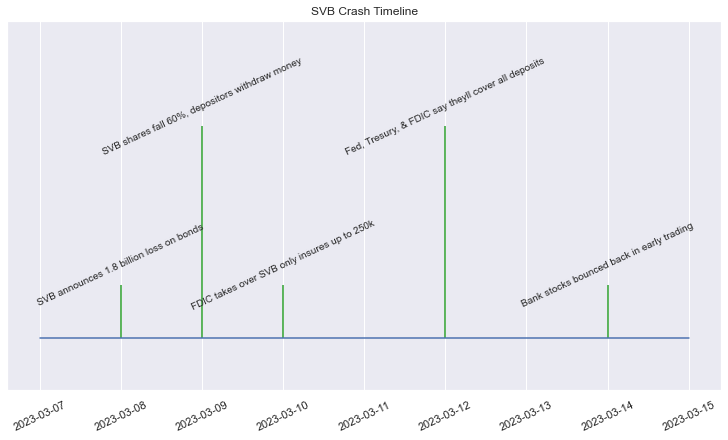

In [68]:
levels = np.tile([0, 1,4, 1, 4,1, 0], int(np.ceil(len(dates)/5)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
ax.set(title="SVB Crash Timeline")

ax.vlines(dates, 0, levels, color="tab:green")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates))  # Baseline and markers on it.



for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l), xytext=(0, 1* 20),# 0 means no horizontal offset and 1*20 means annotation will be 20 spaces from the end of the stem
                textcoords="offset points", horizontalalignment="center",
                verticalalignment="center", rotation=25, fontsize = 10)  # Rotate the text by 45 degrees

ax.set_ylim(-1, 6)
ax.yaxis.set_visible(False)
plt.xticks(rotation=25)
plt.show()

## Google trend search of the keyword "svb" 

In [69]:
# svb_google = pd.read_csv('svb_google_trend.csv')

# import matplotlib.dates as mdates

In [70]:

# svb_google['Day'] = pd.to_datetime(svb_google['Day'])

# # Filter the DataFrame to only include dates at a five-day interval
# df_filtered = svb_google[svb_google['Day'].dt.day % 1 == 0]

# x = df_filtered['Day']
# y = df_filtered['SVB: (District of Columbia)']


# # Create a DateFormatter object
# date_formatter = mdates.DateFormatter('%m-%d')

# # Set the DateFormatter as the major formatter for the x-axis
# plt.gca().xaxis.set_major_formatter(date_formatter)

# plt.plot(x, y)

# plt.xlabel('Date')
# plt.ylabel('Interest Over Time')

# plt.title('Interest over time of "SVB"')

# plt.show()


In [71]:
# df.head()

## Get list of companies in S&P500

We will obtain and store the list of the constituents from Wikipedia.

In [72]:
data    = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S%26P_500_component_stocks')
table_symbol   = data[0]
table_industry = data[0]['GICS Sector']
symbols = list(table_symbol.Symbol.values) ##companies
industries = list(table_industry.values) ##Industry Sector

symbols_industries_dict = {}
symbols_industries = data[0].iloc[:, [0,2]].values.tolist()
for pair in symbols_industries:
  keys, values = pair
  symbols_industries_dict[keys] = values

print("{} symbols in total".format(len(symbols)))
print("{} industries in total".format(len(industries)))
print(industries)


503 symbols in total
503 industries in total
['Industrials', 'Industrials', 'Health Care', 'Health Care', 'Information Technology', 'Consumer Staples', 'Information Technology', 'Industrials', 'Utilities', 'Financials', 'Health Care', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Industrials', 'Materials', 'Real Estate', 'Health Care', 'Industrials', 'Utilities', 'Financials', 'Communication Services', 'Communication Services', 'Consumer Staples', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Utilities', 'Industrials', 'Utilities', 'Financials', 'Financials', 'Real Estate', 'Utilities', 'Financials', 'Industrials', 'Health Care', 'Information Technology', 'Information Technology', 'Information Technology', 'Financials', 'Energy', 'Information Technology', 'Information Technology', 'Consumer Discretionary', 'Financials', 'Information Technology', 'Financials', 'Financials', 'Communication Services', 'Utilities', 'Information Technology', 'Consumer

## Download price timeseries

Now that we have a list of ticker symbols, we can download the corresponding timeseries from Yahoo Finance.

In [73]:
symbols.append('SPY')

In [74]:
dates = '_{}--{}'.format(start_date, end_date)
dates

'_2023-03-02--2023-03-21'

In [75]:
'''
try:
  os.mkdir(data_dir)
except:
  print("Dir Error")
  '''

os.makedirs(data_dir, exist_ok=True)

In [76]:
#!ls /data


##Trying to get other types of timeseries data from yfinance
i want to get daily market cap i think

In [77]:
# ticker = yf.Ticker("AAPL")
# history = ticker.history(period="30d")
# market_cap = history["Close"] * ticker.info["marketCap"]
# market_cap.head()

below w

In [78]:
# symbols = sorted(symbols)
# print("Downloading {} files".format(len(symbols)))
# for i, symbol in enumerate(symbols):
#     try:
#         df = web.get_data_yahoo(symbol, start_date, end_date,)
#         # df = web.DataReader(symbol,'yahoo', start_date, end_date)
#         df = df[['Adj Close','Volume']]
#         df.to_csv(os.path.join(data_dir, "{}.csv".format(symbol)))
#     except KeyError:
#       print("Error for {}".format(symbol))
#       pass
# print("Stored {} files".format(i+1))



symbols = sorted(symbols)
print("Downloading {} files".format(len(symbols)))

for i, symbol in enumerate(symbols):
    # Check if the file for this symbol already exists in the data folder.
    file_path = os.path.join(data_dir, "{}.csv".format(symbol))
    if os.path.exists(file_path):
        print("Skipping download for {}.".format(symbol))
        continue

    try:
        # Download the file for this symbol.
        df = web.get_data_yahoo(symbol, start_date, end_date,)
        # df = web.DataReader(symbol,'yahoo', start_date, end_date)
        df = df[['Adj Close','Volume']]
        df.to_csv(file_path)
    except KeyError:
      print("Error for {}".format(symbol))
      pass

print("Stored {} files".format(i+1))


Skipping download for A.
Skipping download for AAL.
Skipping download for AAPL.
Skipping download for ABBV.
Skipping download for ABNB.
Skipping download for ABT.
Skipping download for ACGL.
Skipping download for ACN.
Skipping download for ADBE.
Skipping download for ADI.
Skipping download for ADM.
Skipping download for ADP.
Skipping download for ADSK.
Skipping download for AEE.
Skipping download for AEP.
Skipping download for AES.
Skipping download for AFL.
Skipping download for AIG.
Skipping download for AIZ.
Skipping download for AJG.
Skipping download for AKAM.
Skipping download for ALB.
Skipping download for ALGN.
Skipping download for ALK.
Skipping download for ALL.
Skipping download for ALLE.
Skipping download for AMAT.
Skipping download for AMCR.
Skipping download for AMD.
Skipping download for AME.
Skipping download for AMGN.
Skipping download for AMP.
Skipping download for AMT.
Skipping download for AMZN.
Skipping download for ANET.
Skipping download for ANSS.
Skipping downlo

In [79]:
# Printing a sample dataframe
idx = np.random.randint(len(symbols))
print("History for {}".format(symbols[idx]))
df = pd.read_csv(os.path.join(data_dir, symbols[idx]+".csv")).set_index('Date')
df.head()

History for ADM


,Adj Close,Volume
Date,,
2023-03-02,79.668991,2772500
2023-03-03,80.153519,1866800
2023-03-06,80.489716,2764500
2023-03-07,78.838394,2400800
2023-03-08,79.016380,1667300


## Pre-process Financial Timeseries

In [80]:
index = pd.date_range(start=start_date, end=end_date, freq='D')     # initialize an empty DateTime Index and so each index is a date over the month
df_price = pd.DataFrame(index=index, columns=symbols)               # initialize empty dataframes
df_volume = pd.DataFrame(index=index, columns=symbols)

In [81]:
# Aggregate all symbols into a price dataframe and volume dataframe
#for each ticker symbol get that csv file, set the index of that to the datetimes
#for each column in df_price is that company's adj price every datetime
for symbol in symbols:
    symbol_df = pd.read_csv(os.path.join(data_dir, symbol+".csv")).set_index('Date')
    symbol_df.index = pd.to_datetime(symbol_df.index)

    df_price[symbol] = symbol_df['Adj Close']
    df_volume[symbol] = symbol_df['Volume']

### Removing NaNs

In [82]:
# Let's drop the dates where all the stocks are NaNs, ie., weekends/holidays where no trading occured
df_price.dropna(how='all', inplace=True)
df_volume.dropna(how='all', inplace=True)
df_price.dropna(inplace=True, axis=1)
df_volume.dropna(inplace=True, axis=1)
assert((df_price.index == df_volume.index).all())

In [83]:
True in pd.isna(df_price)

False

### Storing the cleaned dataframes

In [84]:
#so instead of 500 csv files its now two
df_price.to_csv(os.path.join(data_dir, "prices.csv"), index_label='date')
df_volume.to_csv(os.path.join(data_dir, "volume.csv"))

#finds percent change between current price and prior
df_price_pct = df_price.pct_change()[1:]
df_price_pct.to_csv(os.path.join(data_dir, "prices_pct.csv"), index_label='date')
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2023-03-03,0.015953,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.021338,0.011812,0.012657,0.028132,0.016332,0.007693,0.026262,0.011076,0.019044,0.011745
2023-03-06,-0.004864,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.003712,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218
2023-03-07,-0.020247,0.014888,-0.014496,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.019411,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560
2023-03-08,0.004062,0.014059,0.008377,-0.021774,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.003358,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015593,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.034437,-0.002329,-0.007729,-0.022661,-0.012676,-0.005758,0.003609,-0.033087,-0.113967,-0.006819


In [85]:
df_price.pct_change()[1:].to_csv(os.path.join(data_dir, 'prices_pct'+dates+'.csv'), index_label='date')
df_price.to_csv(os.path.join(data_dir, 'prices'+dates+'.csv'), index_label='date')

## Obtain Percentage Change and Correlation

We need to convert prices to percent change in price as opposed to the actual \$ price. This is because stocks with very similar prices can behave very differently and vice-versa.
For e.g., if a stock moves from \$100 to \$110, we want the price column to say 10% (indicating the change).

However, for volume, we will retain magnitude.

Spearman correlation

In [86]:
df_price_pct = df_price.pct_change().dropna(how='all')
df_volume_pct = df_volume.pct_change().dropna(how='all')

### Calculate Correlations

In [87]:
price_corr = df_price_pct.corr()
volume_corr = df_volume.corr()

In [88]:
price_corr.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.518886,0.791644,0.374021,0.633633,0.810017,0.844037,0.907141,0.633081,0.872987,...,0.769745,0.302470,0.665963,0.743985,0.842872,0.723937,0.581283,0.822347,0.232826,0.829995
AAL,0.518886,1.000000,0.363977,-0.151064,0.736561,0.168846,0.642950,0.615690,0.609986,0.667913,...,0.739896,-0.394523,0.452224,0.273453,0.530967,0.064474,0.102184,0.648352,0.545734,0.338240
AAPL,0.791644,0.363977,1.000000,0.431611,0.610112,0.781190,0.553825,0.815993,0.691610,0.642085,...,0.712922,0.532877,0.515753,0.803461,0.644941,0.761709,0.446680,0.716757,0.305478,0.782669
ABBV,0.374021,-0.151064,0.431611,1.000000,0.339879,0.705052,0.322699,0.290110,0.224161,0.327989,...,0.359327,0.294439,0.311519,0.674334,0.404991,0.548516,0.709123,0.218785,0.018604,0.133280
ABNB,0.633633,0.736561,0.610112,0.339879,1.000000,0.482642,0.751249,0.783877,0.845854,0.700262,...,0.805316,-0.174716,0.398855,0.569476,0.545922,0.349104,0.265398,0.693478,0.571563,0.435600


Text(0.5, 1.0, 'Correlation heatmap for Volume')

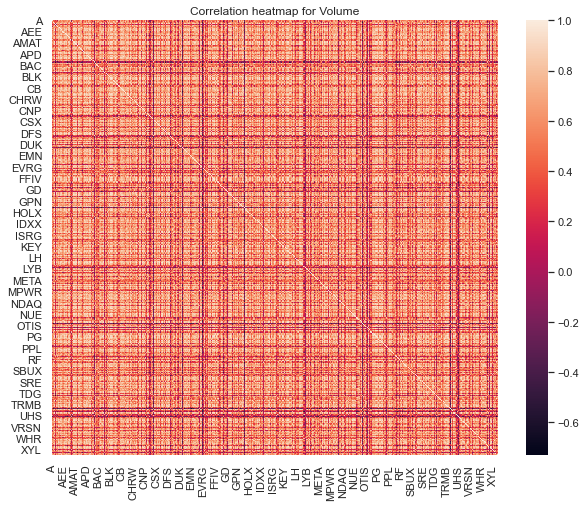

In [89]:
sns.heatmap(volume_corr).set_title("Correlation heatmap for Volume")

Text(0.5, 1.0, 'Correlation heatmap for Price Changes')

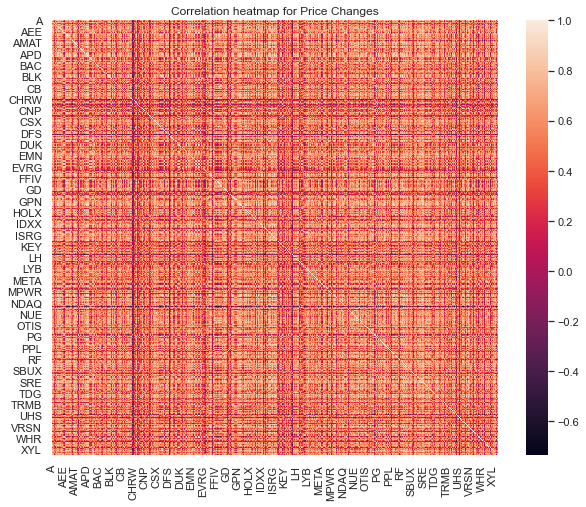

In [90]:
sns.heatmap(price_corr).set_title("Correlation heatmap for Price Changes")

### Examining correlations further

In [91]:
df_price_pct['JPM'].head()

2023-03-03    0.018360
2023-03-06   -0.005847
2023-03-07   -0.029408
2023-03-08   -0.005915
2023-03-09   -0.054136
Name: JPM, dtype: float64

Text(0.5, 1.0, 'Price Change Scatterplot between JPM and GS. Correlation = 0.5898310965704259')

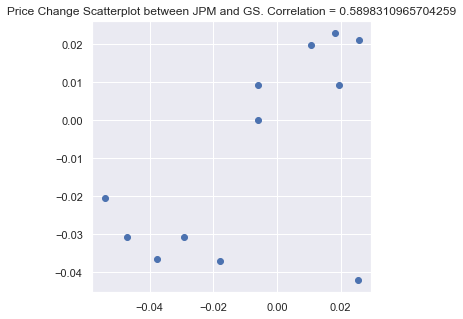

In [92]:
plt.figure(figsize=(5,5))
plt.scatter(df_price_pct['JPM'], df_price_pct['GS'])
plt.title('Price Change Scatterplot between JPM and GS. Correlation = {}'.format(price_corr['JPM']['GS']))

Summary statistics for the df_price_pct and df_volume dataframes and then boxplots to find outliers

In [93]:
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2023-03-03,0.015953,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.021338,0.011812,0.012657,0.028132,0.016332,0.007693,0.026262,0.011076,0.019044,0.011745
2023-03-06,-0.004864,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.003712,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218
2023-03-07,-0.020247,0.014888,-0.014496,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.019411,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560
2023-03-08,0.004062,0.014059,0.008377,-0.021774,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.003358,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015593,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.034437,-0.002329,-0.007729,-0.022661,-0.012676,-0.005758,0.003609,-0.033087,-0.113967,-0.006819


# Summary Stats and Outliers?
The below box plot is showing the price percentage change averaged across all 500 companies for each day, there's no outliers so it doesn't seem like theres one day in the timeseries where all the companies are all having drastic movement.




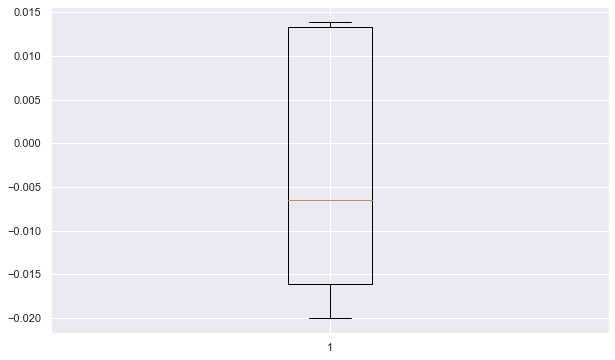

count    12.000000
mean     -0.003670
std       0.014266
min      -0.020047
25%      -0.016108
50%      -0.006513
75%       0.013279
max       0.013903
Name: average, dtype: float64

In [94]:
fig, ax = plt.subplots(figsize=(10, 6))
df_price_plotting = df_price_pct
df_price_plotting['average'] = df_price_plotting.mean(axis=1)
#average across all companies per day



# Creating plot
plt.boxplot(df_price_plotting['average'])

# show plot
plt.show()
df_price_plotting['average'].describe()

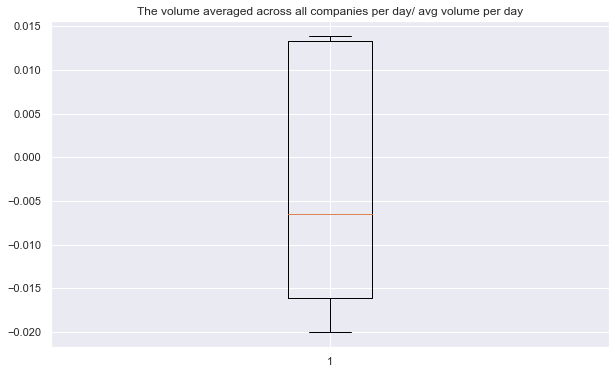

count    12.000000
mean     -0.003670
std       0.014266
min      -0.020047
25%      -0.016108
50%      -0.006513
75%       0.013279
max       0.013903
Name: average, dtype: float64

In [95]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title="The volume averaged across all companies per day/ avg volume per day")
df_volume_summary_stats = df_volume.describe()
df_volume_summary_stats['average'] = df_volume_summary_stats.mean(axis=1)
df_volume_summary_stats['average']


# Creating plot
plt.boxplot(df_price_plotting['average'])

# show plot
plt.show()
df_price_plotting['average'].describe()

### Analyzng the distributions over time

This time instead of averaging every companies price change per day we're going to look at every company's price change over one day and make a separate boxplot to show the changes in distribution across the week of the crash

on march 2nd there was  3  negative outliers and  13 positive outliers in the distribution
on march 9th there was  21  negative outliers and  3 positive outliers in the distribution
on march 15th there was  9  negative outliers and  14 positive outliers in the distribution
on march 19th there was  10  negative outliers and  10 positive outliers in the distribution




[Text(0.5, 1.0, 'Price % changes on march 19th 2023')]

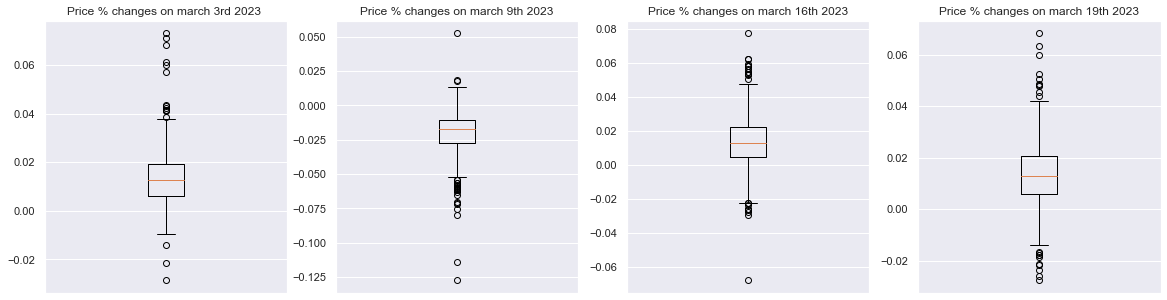

In [96]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20, 5), ncols=4)
bxplt1 = ax1.boxplot(df_price_pct.loc['2023-03-03'])
bxplt2 = ax2.boxplot(df_price_pct.loc['2023-03-09'])
bxplt3 = ax3.boxplot(df_price_pct.loc['2023-03-16'])
bxplt4 = ax4.boxplot(df_price_pct.loc['2023-03-20'])
ax1.xaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax4.xaxis.set_visible(False)

outliers1 = bxplt1["fliers"][0].get_ydata()
outliers2 = bxplt2["fliers"][0].get_ydata()
outliers3 = bxplt3['fliers'][0].get_ydata()
outliers4 = bxplt4['fliers'][0].get_ydata()

neg_outliers1 = outliers1[outliers1<0]
neg_outliers2 = outliers2[outliers2<0]


print('on march 2nd there was ', len(neg_outliers1), ' negative outliers and ', len(outliers1[outliers1>0]), 'positive outliers in the distribution')
print('on march 9th there was ', len(neg_outliers2), ' negative outliers and ', len(outliers2[outliers2>0]), 'positive outliers in the distribution')
print('on march 15th there was ', len(outliers3[outliers3<0]), ' negative outliers and ', len(outliers3[outliers3>0]), 'positive outliers in the distribution')
print('on march 19th there was ', len(outliers4[outliers4<0]), ' negative outliers and ', len(outliers4[outliers4<0]), 'positive outliers in the distribution\n\n')

ax1.set(title="Price % changes on march 3rd 2023 ")
ax2.set(title="Price % changes on march 9th 2023")
ax3.set(title= "Price % changes on march 16th 2023")
ax4.set(title = "Price % changes on march 19th 2023")


This is also shown in the line graph showing how during the week of the crash, healthcare company ABT stayed consistent with the monthly trends while financial company charles schwab had one of its lowest price drops. Tesla, a silicon tech company had big drop on the 9th but rebounded pretty quickly

I wanted to show how the crash affects other sectors besides financial

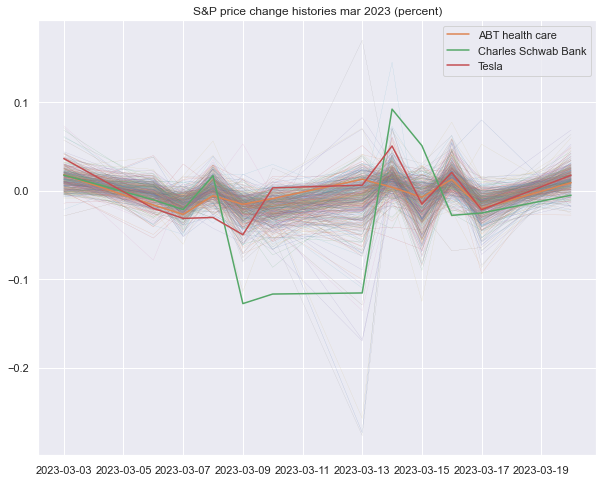

In [97]:
plt.title('S&P price change histories mar 2023 (percent)')
plt.plot(df_price_pct, linewidth=0.10)
plt.plot(df_price_pct['ABT'], label='ABT health care', linewidth=1.5)
plt.plot(df_price_pct['SCHW'], label = 'Charles Schwab Bank', linewidth=1.5)
plt.plot(df_price_pct['TSLA'], label = 'Tesla', linewidth=1.5)
plt.legend()

## <font color= "9900CC">**Not every company reacted the same way**
In the original time series used for the file, JPMC and GS's price changes were consistent with each other throughout the month. However, when we set the timeseries to march 2023, during the week of the SVB crash they diverge drastically, this is because while GS suffered due to uncertaintiy w/ the economy, JPMC was in talks to accquire SVB thus their price sky rocketed so you can't definetively say every financial company suffered due to the crash.

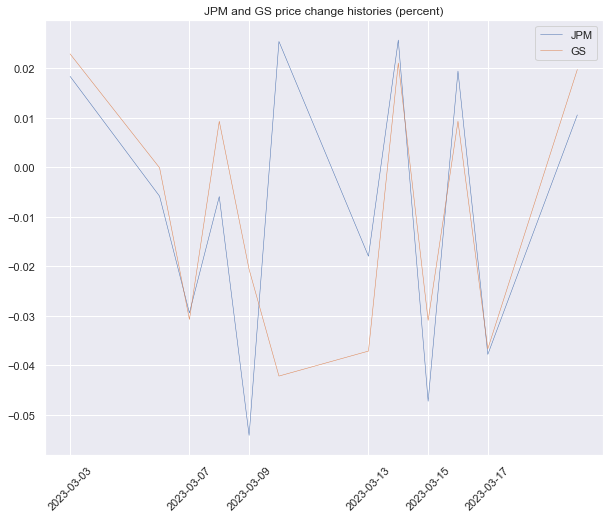

In [98]:
plt.title('JPM and GS price change histories (percent)')
plt.plot(df_price_pct['JPM'], label='JPM', linewidth=0.5)
plt.plot(df_price_pct['GS'], label='GS', linewidth=0.5)
dates = list(df_price_pct.index.values)
plt.xticks([dates[i] for i in range(len(dates)) if i % 2 == 0], rotation=45)
plt.legend()

In [99]:
df_price_pct_summary_stats = df_price_pct.describe()
df_price_pct_summary_stats['average'] = df_price_pct_summary_stats.mean(axis=1)
print('summary statistics for price (not pct change) averaged across all companies')
#df_price_pct_summary_stats.head()
print(df_price_pct_summary_stats['average'])

summary statistics for price (not pct change) averaged across all companies
count    12.000000
mean     -0.003670
std       0.020228
min      -0.037256
25%      -0.017027
50%      -0.003808
75%       0.009791
max       0.029083
Name: average, dtype: float64


## Saving correlation dataframes

In [100]:
#df_price_pct.to_csv(os.path.join(data_dir, 'price_pct.csv'), index_label='date')
price_corr.to_csv(os.path.join(data_dir, 'price_corr.csv'), index_label='Symbol')
volume_corr.to_csv(os.path.join(data_dir, 'volume_corr.csv'))

## CREATE A HEATMAP WITH THRESHOLD OF ONLY ABOVE 0.7(Does it help?)

Text(0.5, 1.0, 'Price Correlation Heatmap')

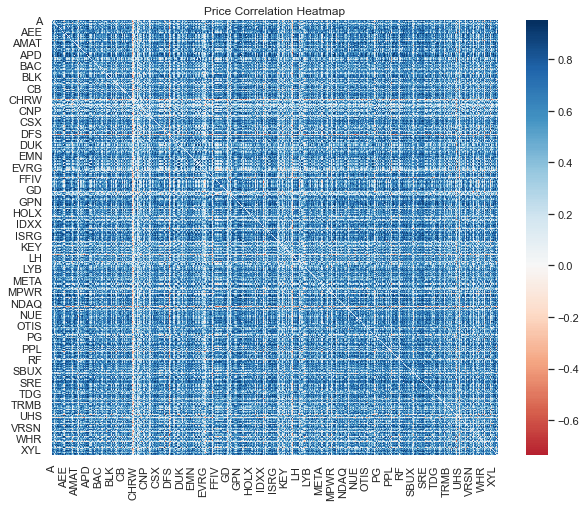

In [101]:

# threshold = 0.7
threshold = 0.95

# Create a mask to hide the upper triangle of the heatmap
mask = price_corr.abs() > threshold

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(price_corr, cmap='RdBu', mask=mask, center=0)
plt.title('Price Correlation Heatmap')


## Use the price corr matrix to graph the correlation

In [102]:
import networkx as nx
import plotly.graph_objects as go

In [103]:
threshold = .95

links = price_corr.stack().reset_index()
links.columns = ['company1', 'company2', 'correlation']
#made price_corr go from company names as the row and column indeces to company1 being the first column header, company2 beign the second, and correlation as the third

#filtering out any correlations under the threshold that we will set and getting rid of the self loops in the nodes
links_filtered=links.loc[ (links['correlation'] > threshold) & (links['company1'] != links['company2']) ]
G=nx.from_pandas_edgelist(links_filtered, 'company1', 'company2', edge_attr = 'correlation')
nodes = list(G.nodes)
#df_company_names = pd.DataFrame(nodes, columns=['S&P Names'])
nx.set_node_attributes(G, symbols_industries_dict, 'GICS Sector')



## Adding weights to the edges

I'm going to make the edge color on the graph be a darker blue if the correlation is higher between the nodes

in the code above i set an edge attribute as 'correlation' now im iterating through the links_filtered to get two lists: edges (s,d) and weight (correlation)

in the code block below i set the edgelist to that edges list i just made and set the edge_color to the weights themselves, the colors and numbers map based on the edge c_map (color_map) called plt.cm.Blues

In [104]:
edges = []
weights = []

# Iterate through the edges of the graph and extract 'correlation' as weights
#were making an edges list and a weights list
for edge in G.edges(data=True):
    source, target, weight = edge
    edges.append((source, target))
    weights.append(weight['correlation'])



G is the graph but now I'm playing with different ways to visualize it, the original briefing video mentioned making an interactive graph so i'm going to try that. below is the standard static graph that doesn't tell us much.  you can still tell which nodes are central and which are outliers relative to each other though.

In [105]:
# Making a custom node color map based on sector


val_map = {
    'Materials': 'navy',
    'Consumer Staples': 'purple',
    'Energy': 'teal',
    'Real Estate': 'cyan',
    'Information Technology': 'dodgerblue',
    'Utilities': 'blue',
    'Health Care': 'indigo',
    'Industrials': 'royalblue',
    'Consumer Discretionary': 'skyblue',
    'Communication Services': 'midnightblue',
    'Financials': 'steelblue'
}

#list comprehension cool
node_colors = [val_map.get(G.nodes[node]['GICS Sector']) for node in G.nodes()]

Drawing the network with the custom node color map and edge colormap

it should be noted that i cant make a colormap for the node colors (i could for edges tho) the node colors have literally nothing to do with each other just if its the same color its the same industry

for the edge colors, if the edge is lighter, then the correlation is weaker

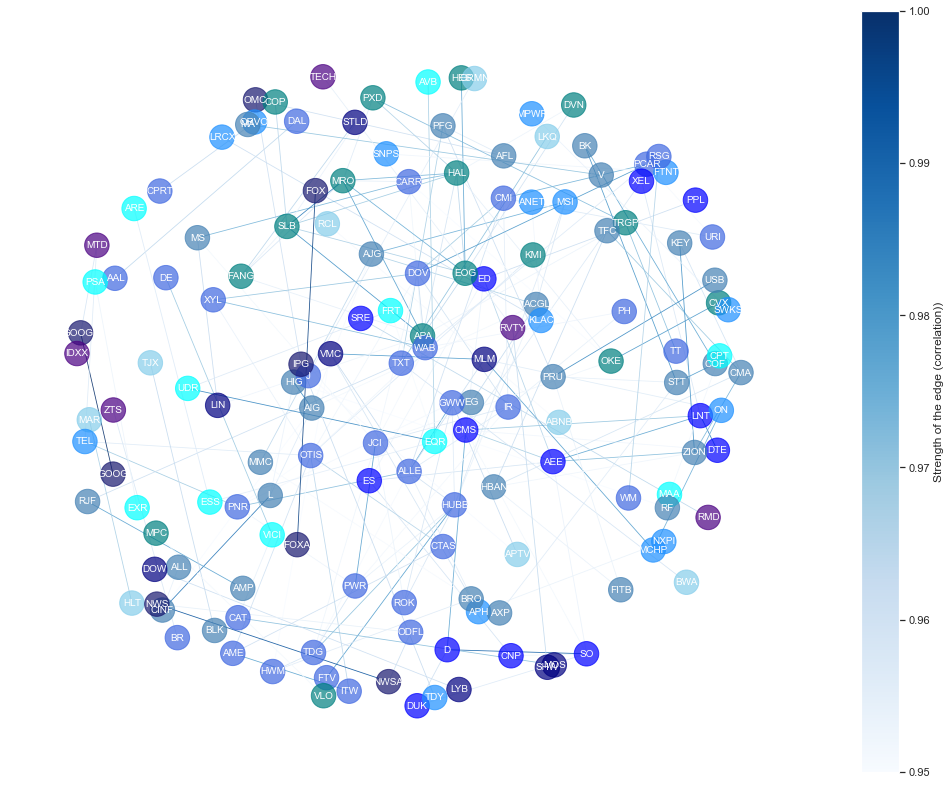

In [106]:
from matplotlib import cm
plt.figure(figsize=(18, 14))


pos = nx.spring_layout(G, k=.7, seed =1234)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodes,
                       node_size=600,
                       node_color=node_colors,
                       alpha=.7)
nx.draw_networkx_edges(G,pos,
                       edgelist = edges,
                       width=.8,
                       edge_color= weights,
                       edge_cmap = plt.cm.Blues,
                       alpha=0.9)


nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodes,nodes)),
                        font_color='white',
                        font_size = 10)

cmap = cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=threshold, vmax=1))
# Add colorbar directly to the plot
cbar = plt.colorbar(cmap)
cbar.set_label('Strength of the edge (correlation))')

plt.box(False)
plt.show()


## Make it interactive

In [107]:
pos = nx.spring_layout(G, seed=1234) #seed for reproducibility
nx.set_node_attributes(G, pos, 'pos')

In [108]:
# hover text
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(nodes[node]+' # of connections: '+str(len(adjacencies[1])))

## Edge Trace
So for plotly you cant just import a premade graph you have to trace over every node and edge and put into the plotly scatter plot

uses the spring layout positions to get the coordinates of the first node and second node in the edge to make the edge_x[] and edge_y[]

edge trace takes those arrays and traces them with a thin grey line

In [109]:
###Custom Color Map for the edges you cant use a colorscale i think i need to do this manually

import matplotlib.cm as cm
normalized_weights = (np.array(weights) - min(weights)) / (max(weights) - min(weights))
num_intervals = 10
colors = np.linspace(0, 1, num_intervals) #start stop intervals

In [110]:
import plotly.graph_objects as go

In [111]:
edge_traces = []

for i, edge in enumerate(G.edges()):
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    # set the color for the current edge based on the normalized weight
    #going to do rgb for the colors
    color_index = int(normalized_weights[i] * (num_intervals - 1))
    color_rgb = f"rgb({int(colors[color_index] * 255)}, {int(colors[color_index] * 255)}, {int(colors[color_index] * 255)}  )" #so because the three rgb values are equal its just going to be in greyscale lol
    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        #hoverinfo='text',
        mode='lines',
        hoverinfo = 'text',
        line=dict(
            width=1.5,
            color=color_rgb,
        )
    )

    edge_traces.append(edge_trace)


## Node Trace
this is setting up the hovertext and the normal text (labels) for the nodes
you set the mode to markers+text to show the labels and the circles, if you do markers+text+lines it'll show additional lines (edges) between nodes that dont make sense in the marker attribute were setting up for the node's color to be depedent on the num of adjacancies

Then custom node color map these colors have nothing to do with each other !!!!!

In [112]:
node_colors = [val_map.get(G.nodes[node]['GICS Sector']) for node in G.nodes()]

# Node Positions
node_x = []
node_y = []

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

# Node Trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    hoverinfo='text',
    text=list(G.nodes()),
    hovertext=node_text,
    textposition='top right',
    mode='markers+text',
    marker=dict(
        color=node_colors,
        size=10,
        line_width=1
    ))

In [113]:
# ! pip install --upgrade nbformat

In [114]:
fig = go.Figure(data=edge_traces + [node_trace],
             layout=go.Layout(
                title='<br>Correlation of S&P Companies based on Price Change',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Show the Figure
fig.show()

<b>Correlation Analysis - clustering</b><br></br>
Group companies together using clustering techniques
Then, apply statistical methods, such as correlation analysis, to identify relationships and patterns within the company graph


Hiericharical clustering:
- Distance computing 

Dendrogram: 
- Single linkage
        - A distance between clusters in the tree is calculated using the shortest distance between them.
- Average linkage (UPGMA) - A distance between clusters in the tree is calculated using average distance between them.
- Complete linkage - A distance between clusters in the tree is calculated using the longest distance between them.
- Ward - At every step of clustering two clusters that result into a minimal loss of information are combined. Information loss is measured using error sum-of-squares criterion.




Steps for clustering based on price change:
step 0: decide the number of clusters required, which is the threshold of abs value of 95%
step 1: create a scatter plot
step 2: normalize the data
step 3: calculate eclidean distance
step 4: create a dendogram



In [115]:
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,average
2023-03-03,0.015953,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.011812,0.012657,0.028132,0.016332,0.007693,0.026262,0.011076,0.019044,0.011745,0.013512
2023-03-06,-0.004864,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218,-0.004382
2023-03-07,-0.020247,0.014888,-0.014496,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560,-0.015828
2023-03-08,0.004062,0.014059,0.008377,-0.021774,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639,0.002339
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015593,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.002329,-0.007729,-0.022661,-0.012676,-0.005758,0.003609,-0.033087,-0.113967,-0.006819,-0.020037


In [116]:
dissimilarity = 1 - abs(df_price_pct.corr().values) #whether to use absolute value or not

In [117]:
# print(dissimilarity.shape) #The shape is: (501, 501), so we are good to go
# Since we have the correlation of itself to be 0, the next is to 
dissimilarity


array([[0.        , 0.48111373, 0.20835612, ..., 0.76717391, 0.17000528,
        0.10056304],
       [0.48111373, 0.        , 0.6360227 , ..., 0.45426572, 0.66176021,
        0.41054658],
       [0.20835612, 0.6360227 , 0.        , ..., 0.69452211, 0.21733074,
        0.15721923],
       ...,
       [0.76717391, 0.45426572, 0.69452211, ..., 0.        , 0.91379603,
        0.44320219],
       [0.17000528, 0.66176021, 0.21733074, ..., 0.91379603, 0.        ,
        0.21261791],
       [0.10056304, 0.41054658, 0.15721923, ..., 0.44320219, 0.21261791,
        0.        ]])

In [118]:
# Cluster: build the linkage matrix
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform



In [119]:

from scipy.cluster.hierarchy import *
complete_linkage = linkage(squareform(dissimilarity), method = 'complete')

Why do we use complete linkage here? 
It takes the maximum distance between the two clusters. 

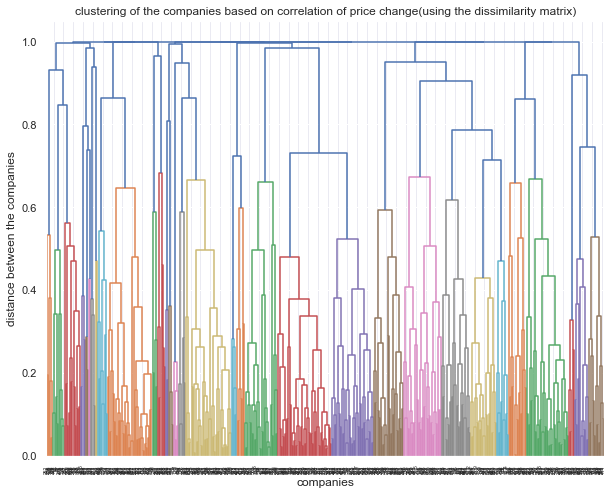

In [120]:
dendrogram = dendrogram(complete_linkage)

plt.xlabel("companies")
plt.ylabel("distance between the companies")

plt.title("clustering of the companies based on correlation of price change(using the dissimilarity matrix)")
plt.show()

In [121]:
#show the first ten companies of the dissimilarity matrix to see if it makes sense
dissimilarity[:10,:10]


array([[0.        , 0.48111373, 0.20835612, 0.62597916, 0.36636741,
        0.18998272, 0.15596306, 0.09285853, 0.36691929, 0.12701271],
       [0.48111373, 0.        , 0.6360227 , 0.84893612, 0.2634394 ,
        0.83115377, 0.3570504 , 0.38430993, 0.39001421, 0.33208747],
       [0.20835612, 0.6360227 , 0.        , 0.56838892, 0.38988783,
        0.21881009, 0.44617459, 0.18400741, 0.30839002, 0.35791491],
       [0.62597916, 0.84893612, 0.56838892, 0.        , 0.66012147,
        0.29494804, 0.67730055, 0.70988995, 0.77583932, 0.67201086],
       [0.36636741, 0.2634394 , 0.38988783, 0.66012147, 0.        ,
        0.51735787, 0.24875086, 0.21612321, 0.15414575, 0.29973837],
       [0.18998272, 0.83115377, 0.21881009, 0.29494804, 0.51735787,
        0.        , 0.47434135, 0.3008609 , 0.49794644, 0.36844894],
       [0.15596306, 0.3570504 , 0.44617459, 0.67730055, 0.24875086,
        0.47434135, 0.        , 0.15165079, 0.33589453, 0.16782579],
       [0.09285853, 0.38430993, 0.1840074

In [133]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

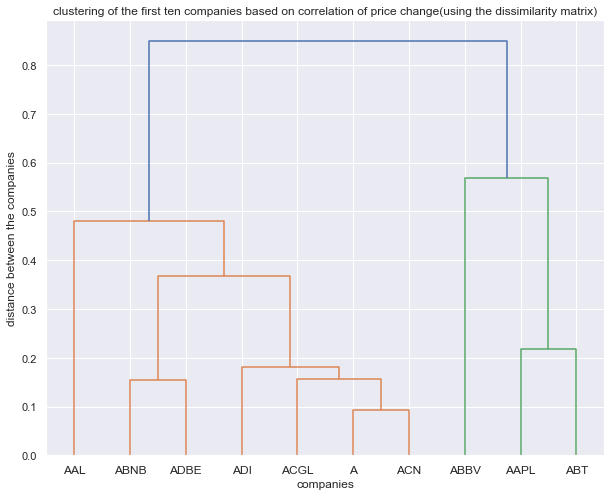

In [135]:
dissimilarity_10 = dissimilarity[:10,:10]
complete_linkage_10 = linkage(squareform(dissimilarity_10), method = 'complete')
dendrogram_10 = dendrogram(complete_linkage_10, labels=df_price_pct.columns[:10])
plt.xlabel("companies")
plt.ylabel("distance between the companies")
plt.title("clustering of the first ten companies based on correlation of price change(using the dissimilarity matrix)")
plt.show()


In [ ]:
# #use elbow method to find the optimal number of clusters
# from scipy.spatial.distance import cdist


In [141]:
# fcluster forms flat clusters from the hierarchical clustering defined by the given linkage matrix.

max_d = 0.5
clusters = fcluster(complete_linkage_10,t=max_d, criterion='distance')

In [142]:
# df_clust = pd.DataFrame({'Cluster':clusters, 'Features':df_price_pct.columns.values.astype('str')})
df_clust = pd.DataFrame({'Cluster':clusters, 'Features':df_price_pct.columns[:10]})
df_clust.groupby('Cluster').count()



,Features
Cluster,
1,7
2,2
3,1


In [143]:
# zoom out and apply to the whole 500 x 500 matrix
max_d = 0.5 #max_d is the max distance between two clusters
clusters = fcluster(complete_linkage,t=max_d, criterion='distance')
df_clust = pd.DataFrame({'Cluster':clusters, 'Features':df_price_pct.columns})
df_clust.groupby('Cluster').count()


,Features
Cluster,
1,2
2,4
3,10
4,3
5,11
6,1
7,4
8,3
9,2


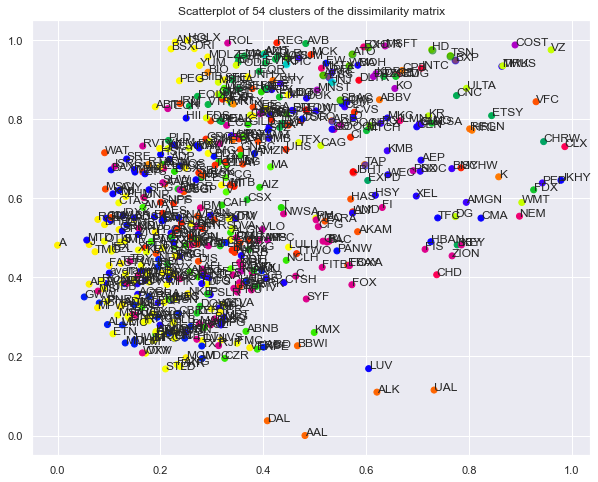

In [148]:
#create a scatterplot of 54 clusters of the dissimilarity matrix
plt.figure(figsize=(10, 8))
plt.scatter(dissimilarity[:,0], dissimilarity[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.title('Scatterplot of 54 clusters of the dissimilarity matrix')
#label the points
for i, txt in enumerate(df_price_pct.columns):
    plt.annotate(txt, (dissimilarity[i,0], dissimilarity[i,1]))
    
# cirlce the ones that are in one cluster
plt.scatter(dissimilarity[clusters==1,0], dissimilarity[clusters==1,1], c='red', s=50, alpha=0.5);
plt.scatter(dissimilarity[clusters==2,0], dissimilarity[clusters==2,1], c='blue', s=50, alpha=0.5);
plt.scatter(dissimilarity[clusters==3,0], dissimilarity[clusters==3,1], c='green', s=50, alpha=0.5);
plt.scatter(dissimilarity[clusters==4,0], dissimilarity[clusters==4,1], c='cyan', s=50, alpha=0.5);
plt.show()




In [ ]:
# What to do next with the clusters?
# 1. Find the most representative company for each cluster
# 3. Predict the next day's price change for each company based on the cluster it belongs to

# How to find the most representative company for each cluster?
# 1. Find the most similar company to the centroid of each cluster
# 2. Find the company with the highest average correlation to other companies in the same cluster


## Grouping the companies based on the daily return?


Now we have the dendrogram and the clusters of the 500 companies into 54 clusters, it's time to create a prediction based on the number of clusters we have. 
How to approach it? test on the 10 sample companies first. 

# Building the Model- using XGboost to predict 